In [1]:
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn import image as nimg
from nilearn import plotting as nplot
%matplotlib inline

In [91]:
bids_dir = Path("/work/816119/InSpePosNegData/BIDS_2023E")
path_to_first_level = Path("/work/LauraBockPaulsen#1941/fMRI_analysis/flms")

In [92]:
subjects = ["0116"]#, "0117", "0118", "0119", "0120", "0121", "0122", "0123"]

for subject in subjects:
    # get subject flm 
    subject_flm = pickle.load(open(path_to_first_level / f"flm_{subject}.pkl", "rb"))

    # get subject bold for all runs
    subject_BOLD = []
    for run in [1, 2, 3, 4, 5, 6]:
        bold_path = bids_dir / "derivatives" / f"sub-{subject}" / "func" / f"sub-{subject}_task-boldinnerspeech_run-{run}_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

        subject_BOLD.append(bold_path)


# Parcel to get visual area voxels

In [93]:
# ensure that the atlas is downloaded
atlas_path = Path("../atlases")

if not atlas_path.exists():
    atlas_path.mkdir()

atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011(atlas_path)

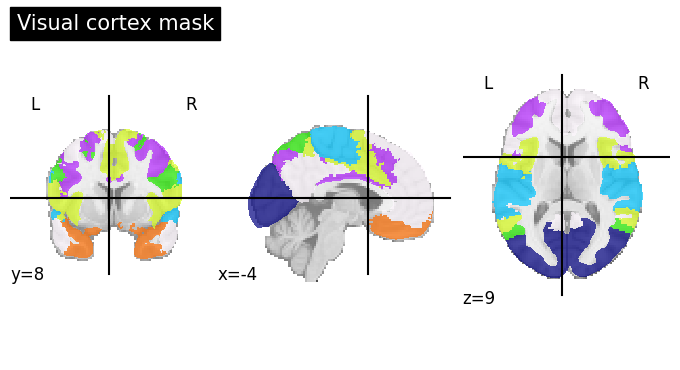

In [94]:

roi_labels = nimg.load_img(atlas_yeo_2011["thick_7"])
nplot.plot_roi(roi_labels, title="Visual cortex mask")

In [95]:
func_img = nib.load(subject_BOLD[0])

In [96]:
print('Size of functional image:', func_img.shape)
print('Size of atlas image:', roi_labels.shape)

# we have to resample
resampled_labels= nimg.resample_to_img(roi_labels, func_img, interpolation = 'nearest')
print('Size of resampled atlas image:', resampled_labels.shape)

Size of functional image: (78, 92, 78, 490)
Size of atlas image: (256, 256, 256, 1)
Size of resampled atlas image: (78, 92, 78, 1)


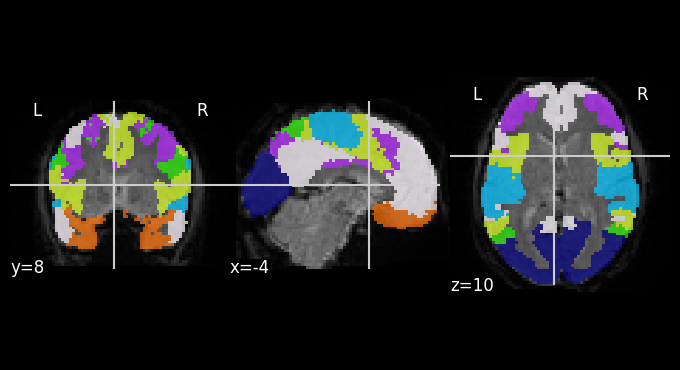

In [97]:
# plotting our parcels over the bold
nplot.plot_roi(resampled_labels, func_img.slicer[:, :, :, 54])

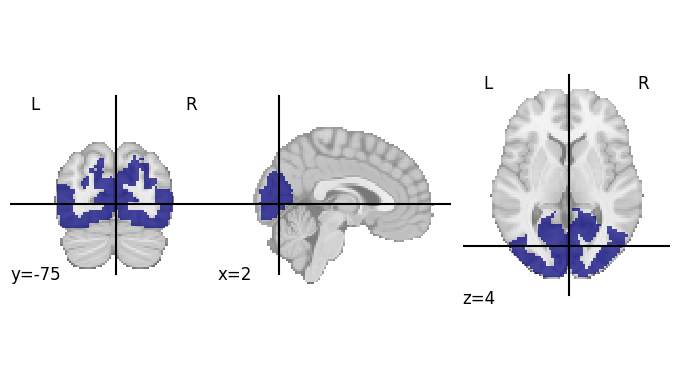

In [98]:
# Make a mask for ROI 1 (visual area)
roi_mask_visual = nimg.math_img('a == 1', a=resampled_labels)  

# Visualize ROI
nplot.plot_roi(roi_mask_visual)

In [99]:
# apply the mask to the bold
from nilearn import input_data

masker = input_data.NiftiMasker(mask_img=roi_mask_visual, standardize=True)
masked_data = masker.fit_transform(func_img)

# average in visual cortex
visual_bold = np.mean(masked_data, axis=1)

/work/LauraBockPaulsen#1941/fMRI_analysis/env/lib/python3.10/site-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


Text(0.5, 1.0, 'Average BOLD signal in visual cortex')

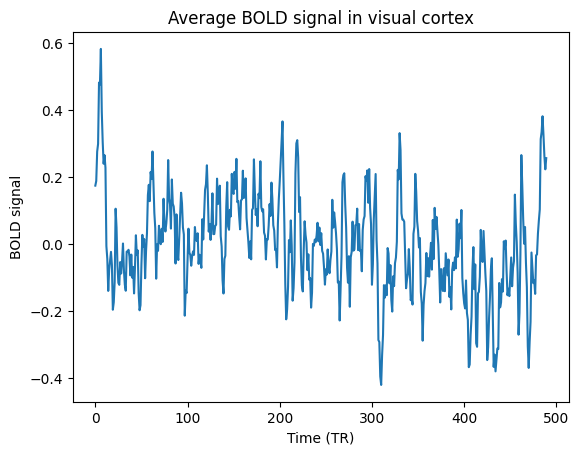

In [100]:
# plot the average time series
plt.plot(visual_bold)
plt.xlabel('Time (TR)')
plt.ylabel('BOLD signal')
plt.title('Average BOLD signal in visual cortex')



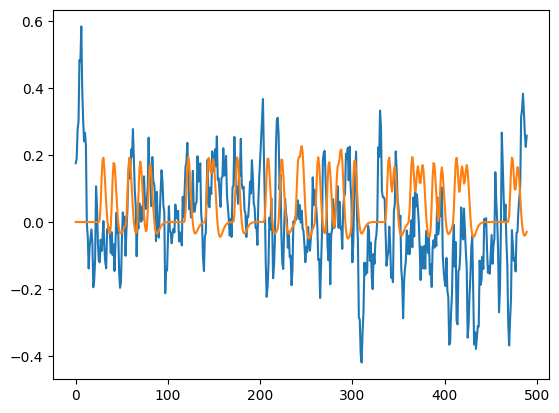

In [101]:
# get the design matrix
X = subject_flm.design_matrices_[0]

# get the regressor of interest
X_visual = X['positive']


# plot the regressor of interest on top of the average time series
plt.plot(visual_bold)
plt.plot(X_visual)

In [105]:
visual_bold @ X

IMG_button     -0.079925
button_press   -0.144364
negative        0.481681
positive       -0.115341
trans_x        -0.104828
trans_y        -0.196434
trans_z        -1.909349
rot_x          -0.018527
rot_y          -0.043100
rot_z           0.005377
drift_1         1.126785
drift_2        -0.325115
drift_3        -0.382166
drift_4         0.162638
drift_5        -0.124740
drift_6         0.752854
drift_7        -0.201064
drift_8         0.395223
drift_9        -0.334845
constant        0.000023
dtype: float64

## Plotting button press contrast

In [2]:
path_to_first_level = Path("/work/LauraBockPaulsen#1941/fMRI_analysis/flms")
flm_files = [f for f in path_to_first_level.iterdir() if f.is_file()]

flms = []

for model in flm_files: # looping over the flms and loading them
    flm_model = pickle.load(open(model,'rb')) 
    flms.append(flm_model)

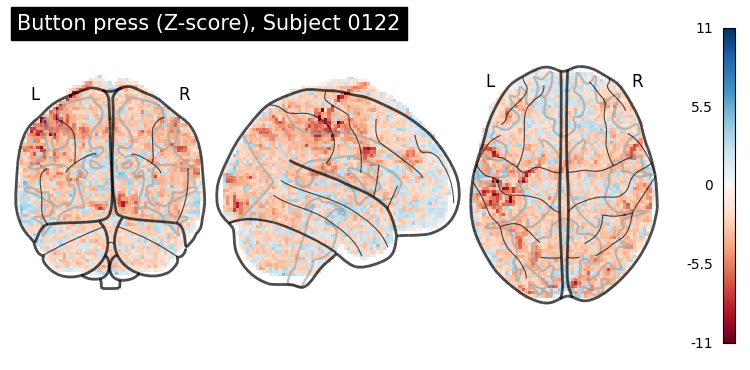

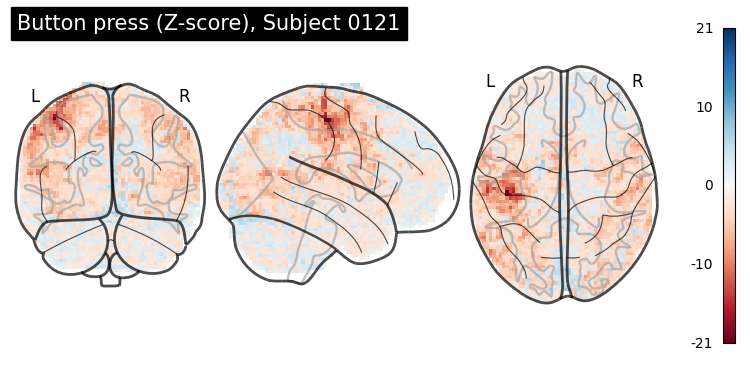

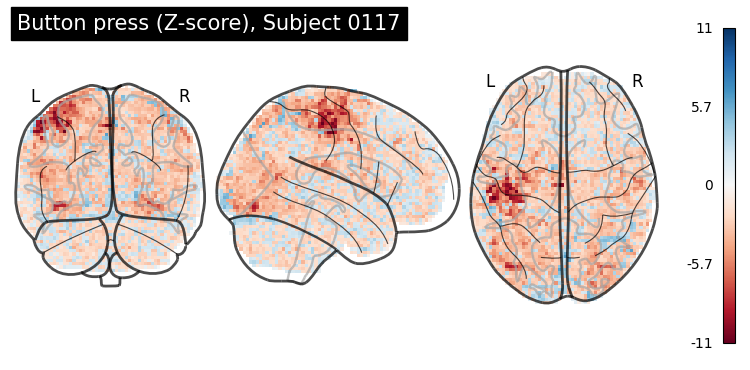

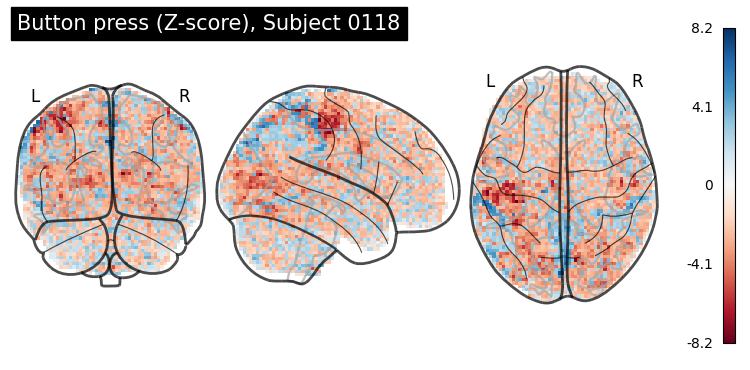

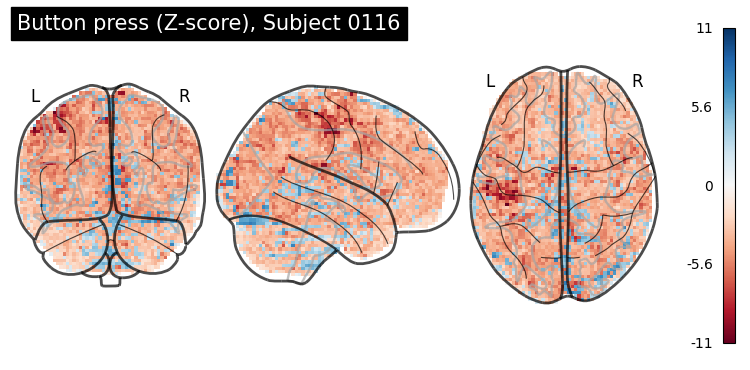

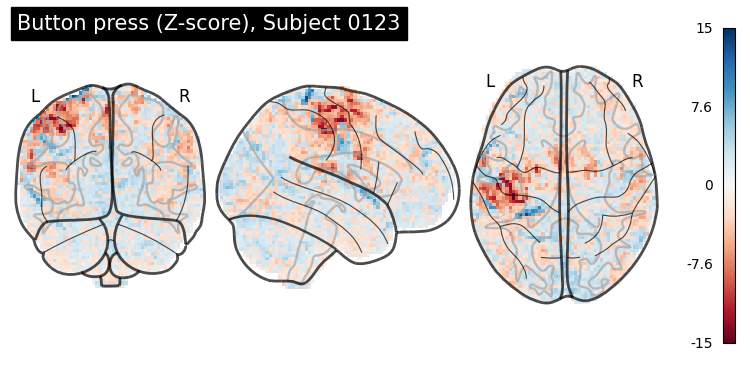

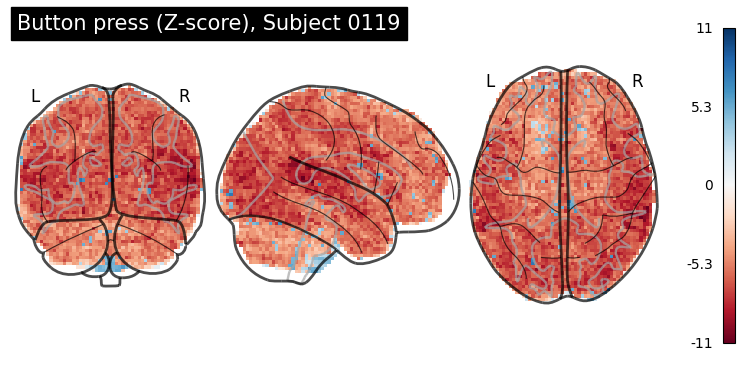

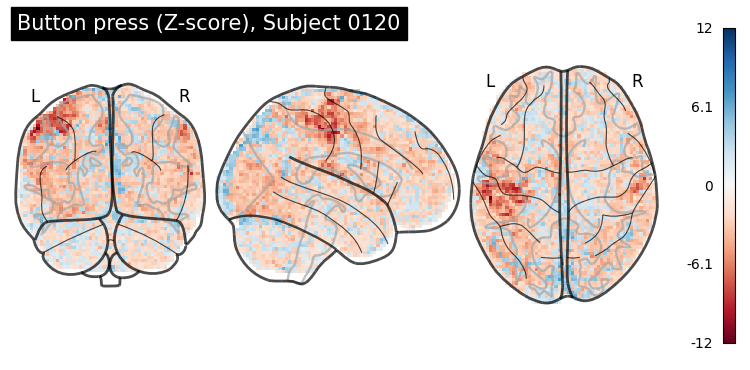

In [14]:
from nilearn import plotting

for flm, file_name in zip(flms, flm_files):
    z_map = flm.compute_contrast("button_press", output_type='z_score')

    plotting.plot_glass_brain(z_map, colorbar=True,
                            title=f"Button press (Z-score), Subject {file_name.stem[-4:]}",
                            plot_abs=False, cmap='RdBu')
    plotting.show()